In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix, matthews_corrcoef, accuracy_score, balanced_accuracy_score
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.preprocessing import RobustScaler
import matplotlib.pyplot as plt
import random

2025-02-13 21:07:47.761063: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1739480867.783511  245222 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1739480867.789890  245222 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-13 21:07:47.814334: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Set random seeds for reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)
tf.keras.utils.set_random_seed(SEED)  # This sets all random seeds in keras
tf.config.experimental.enable_op_determinism()  # For complete reproducibility

In [3]:
def load_prot_t5_data(pos_file, neg_file):
    """Load ProtT5 embeddings and align with existing data"""
    # Read positive and negative files
    pos_data = []
    with open(pos_file, 'r') as f:
        for line in f:
            parts = line.strip().split(',')
            entry = parts[0]
            pos = int(parts[1])
            embeddings = [float(x) for x in parts[2:]]
            pos_data.append((entry, pos, embeddings))
            
    neg_data = []
    with open(neg_file, 'r') as f:
        for line in f:
            parts = line.strip().split(',')
            entry = parts[0]
            pos = int(parts[1])
            embeddings = [float(x) for x in parts[2:]]
            neg_data.append((entry, pos, embeddings))
    
    # Convert to dictionaries for easy lookup
    pos_dict = {(entry, pos): emb for entry, pos, emb in pos_data}
    neg_dict = {(entry, pos): emb for entry, pos, emb in neg_data}
    
    return pos_dict, neg_dict

In [4]:
def prepare_aligned_data(seq_struct_df, pos_dict, neg_dict):
    """Align ProtT5 embeddings with sequence+structure data"""
    embeddings = []
    aligned_indices = []
    
    for idx, row in seq_struct_df.iterrows():
        key = (row['entry'], row['pos'])
        emb = pos_dict.get(key) if row['label'] == 1 else neg_dict.get(key)
        
        if emb is not None:
            embeddings.append(emb)
            aligned_indices.append(idx)
    
    # Convert to numpy array
    X_prot_t5 = np.array(embeddings)
    
    # Get aligned sequence+structure data
    aligned_df = seq_struct_df.iloc[aligned_indices]
    
    return X_prot_t5, aligned_df

In [5]:
def prepare_sequence_data(df):
    """Convert sequences to integer encoding"""
    alphabet = 'ARNDCQEGHILKMFPSTWYV-'
    char_to_int = dict((c, i) for i, c in enumerate(alphabet))
    
    sequences = df['sequence'].values
    encodings = []
    
    for seq in sequences:
        try:
            integer_encoded = [char_to_int[char] for char in seq]
            encodings.append(integer_encoded)
        except Exception as e:
            print(f"Error processing sequence: {e}")
            continue
    
    return np.array(encodings)

In [6]:
def prepare_structure_data(df, use_ss=True):
    """Structure data preparation without contacts"""
    features_list = []
    middle_pos = 16  
    
    # Normalize angles to their circular nature
    def normalize_angles(angle_array, pos):
        angles = np.array([arr[pos] for arr in angle_array])
        angle_rad = np.pi * angles / 180.0
        return np.stack([np.sin(angle_rad), np.cos(angle_rad)], axis=-1)
    
    # 1. Process angles
    angles = ['phi', 'psi', 'omega']
    for angle in angles:
        angle_arrays = np.array([np.array(eval(x)) for x in df[angle]])
        angle_features = normalize_angles(angle_arrays, middle_pos)
        features_list.append(angle_features)
        print(f"{angle} features shape: {angle_features.shape}")
    
    # 2. Process SASA
    sasa_arrays = np.array([np.array(eval(x)) for x in df['sasa']])
    scaler = RobustScaler()
    sasa_features = []
    for pos in [middle_pos-1, middle_pos, middle_pos+1]:
        sasa_pos = np.array([arr[pos] for arr in sasa_arrays]).reshape(-1, 1)
        sasa_scaled = scaler.fit_transform(sasa_pos)
        sasa_features.append(sasa_scaled)
    sasa_features = np.concatenate(sasa_features, axis=1)
    features_list.append(sasa_features)
    print(f"SASA features shape: {sasa_features.shape}")
    
    # 3. Process chi angles
    chi_angles = ['chi1', 'chi2', 'chi3', 'chi4']
    for chi in chi_angles:
        chi_arrays = np.array([np.array(eval(x)) for x in df[chi]])
        chi_features = normalize_angles(chi_arrays, middle_pos)
        features_list.append(chi_features)
        print(f"{chi} features shape: {chi_features.shape}")
    
    # 4. Process SS (optional)
    if use_ss:
        ss_arrays = np.array([list(seq) for seq in df['ss']])
        ss_center = ss_arrays[:, middle_pos]
        ss_encoded = np.zeros((len(ss_arrays), 3))
        ss_map = {'H': 0, 'E': 1, 'L': 2}
        for i, ss in enumerate(ss_center):
            ss_encoded[i, ss_map[ss]] = 1
        features_list.append(ss_encoded)
        print(f"SS features shape: {ss_encoded.shape}")
    
    # 5. Process plDDT
    plddt_arrays = np.array([np.array(eval(x)) for x in df['plDDT']])
    plddt_center = np.array([arr[middle_pos] for arr in plddt_arrays]).reshape(-1, 1)
    scaler = RobustScaler()
    plddt_scaled = scaler.fit_transform(plddt_center)
    features_list.append(plddt_scaled)
    print(f"plDDT features shape: {plddt_scaled.shape}")
    
    # Combine all features
    features = np.concatenate(features_list, axis=1)
    print(f"\nFinal combined features shape: {features.shape}")
    print("Feature list lengths:", [f.shape[1] for f in features_list])
    
    return features

In [7]:
def create_seq_struct_model(seq_length=33, struct_features=25):
    """Create model using only sequence and structural features"""
    regularizer = tf.keras.regularizers.l2(0.01)
    
    # 1. Sequence track
    seq_input = tf.keras.layers.Input(shape=(seq_length,), name='sequence_input')
    x_seq = tf.keras.layers.Embedding(21, 21, input_length=seq_length)(seq_input)
    x_seq = tf.keras.layers.Reshape((seq_length, 21, 1))(x_seq)
    x_seq = tf.keras.layers.Conv2D(32, kernel_size=(17, 3), activation='relu', padding='valid')(x_seq)
    x_seq = tf.keras.layers.BatchNormalization()(x_seq)
    x_seq = tf.keras.layers.Dropout(0.4)(x_seq)
    x_seq = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x_seq)
    x_seq = tf.keras.layers.Flatten()(x_seq)
    x_seq = tf.keras.layers.Dense(32, activation='relu', kernel_regularizer=regularizer)(x_seq)
    x_seq = tf.keras.layers.BatchNormalization()(x_seq)
    x_seq = tf.keras.layers.Dropout(0.4)(x_seq)

    # 2. Structure track
    struct_input = tf.keras.layers.Input(shape=(struct_features,), name='structure_input')
    x_struct = tf.keras.layers.Dense(64, activation='relu')(struct_input)
    x_struct = tf.keras.layers.BatchNormalization()(x_struct)
    x_struct = tf.keras.layers.Dropout(0.3)(x_struct)
    x_struct = tf.keras.layers.Dense(32, activation='relu')(x_struct)
    x_struct = tf.keras.layers.BatchNormalization()(x_struct)
    x_struct = tf.keras.layers.Dropout(0.3)(x_struct)

    # Combine features
    combined = tf.keras.layers.Concatenate()([x_seq, x_struct])
    
    # Final layers
    x = tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=regularizer)(combined)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.4)(x)
    outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)

    model = tf.keras.Model(
        inputs=[seq_input, struct_input], 
        outputs=outputs
    )
    
    return model

In [8]:
def print_metrics(y_true, y_pred):
    """
    Print comprehensive evaluation metrics
    
    Parameters:
    y_true: array-like of true labels
    y_pred: array-like of predicted labels
    """
    # Calculate confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    
    # Calculate metrics
    acc = accuracy_score(y_true, y_pred)
    balanced_acc = balanced_accuracy_score(y_true, y_pred)
    mcc = matthews_corrcoef(y_true, y_pred)
    sensitivity = cm[1][1] / (cm[1][1] + cm[1][0])  # True Positive Rate
    specificity = cm[0][0] / (cm[0][0] + cm[0][1])  # True Negative Rate
    
    # Print results
    print(f"Accuracy: {acc:.4f}")
    print(f"Balanced Accuracy: {balanced_acc:.4f}")
    print(f"MCC: {mcc:.4f}")
    print(f"Sensitivity: {sensitivity:.4f}")
    print(f"Specificity: {specificity:.4f}")
    print("Confusion Matrix:")
    print(cm)

In [ ]:
def train_and_evaluate_seq_struct():
    """Training function for sequence and structure model"""
    # Load data
    print("Loading data...")
    train_df = pd.read_csv("../../data/train/structure/processed_features_train.csv")
    test_df = pd.read_csv("../../data/test/structure/processed_features_test.csv")
    
    # Prepare data
    print("Preparing sequence data...")
    X_train_seq = prepare_sequence_data(train_df)
    X_test_seq = prepare_sequence_data(test_df)
    
    print("Preparing structural data...")
    X_train_struct = prepare_structure_data(train_df, use_ss=True)
    X_test_struct = prepare_structure_data(test_df, use_ss=True)
    
    y_train = train_df['label'].values
    y_test = test_df['label'].values
    
    # Shuffle training data
    shuffle_idx = np.random.RandomState(42).permutation(len(y_train))
    X_train_seq = X_train_seq[shuffle_idx]
    X_train_struct = X_train_struct[shuffle_idx]
    y_train = y_train[shuffle_idx]
    
    # Print class distribution
    print("\nTraining set distribution:")
    print(pd.Series(y_train).value_counts())
    print("\nTest set distribution:")
    print(pd.Series(y_test).value_counts())
    
    # Calculate class weights
    total_samples = len(y_train)
    pos_samples = np.sum(y_train == 1)
    neg_samples = np.sum(y_train == 0)
    
    class_weights = {
        0: total_samples / (2 * neg_samples),
        1: total_samples / (2 * pos_samples)
    }
    
    # Cross-validation
    kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    metrics = {'acc': [], 'balanced_acc': [], 'mcc': [], 'sn': [], 'sp': []}
    test_predictions = []
    fold_histories = []
    
    for fold, (train_idx, val_idx) in enumerate(kfold.split(X_train_seq, y_train), 1):
        print(f"\nFold {fold}/5")
        
        # Callbacks
        callbacks = [
            tf.keras.callbacks.EarlyStopping(
                monitor='val_loss',
                patience=7,
                restore_best_weights=True
            ),
            tf.keras.callbacks.ReduceLROnPlateau(
                monitor='val_loss',
                factor=0.5,
                patience=4,
                min_lr=1e-6
            )
        ]
        
        # Create and compile model
        model = create_seq_struct_model(
            seq_length=33,
            struct_features=X_train_struct.shape[1]
        )
        
        model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=5e-4),
            loss='binary_crossentropy',
            metrics=['accuracy']
        )
        
        # Train model
        history = model.fit(
            [X_train_seq[train_idx], X_train_struct[train_idx]], 
            y_train[train_idx],
            validation_data=(
                [X_train_seq[val_idx], X_train_struct[val_idx]], 
                y_train[val_idx]
            ),
            batch_size=32,
            epochs=50,
            callbacks=callbacks,
            class_weight=class_weights,
            verbose=1
        )
        
        fold_histories.append(history.history)
        
        # Plot training history
        plt.figure(figsize=(10, 6))
        plt.plot(history.history['accuracy'], label='Train Accuracy')
        plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
        plt.title(f'Model Accuracy - Fold {fold}')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.show()
        
        # Evaluate on validation set
        val_pred = model.predict(
            [X_train_seq[val_idx], X_train_struct[val_idx]]
        )
        val_pred_binary = (val_pred > 0.5).astype(int)
        
        # Calculate metrics
        cm = confusion_matrix(y_train[val_idx], val_pred_binary)
        metrics['acc'].append(accuracy_score(y_train[val_idx], val_pred_binary))
        metrics['balanced_acc'].append(balanced_accuracy_score(y_train[val_idx], val_pred_binary))
        metrics['mcc'].append(matthews_corrcoef(y_train[val_idx], val_pred_binary))
        metrics['sn'].append(cm[1][1]/(cm[1][1]+cm[1][0]))
        metrics['sp'].append(cm[0][0]/(cm[0][0]+cm[0][1]))
        
        # Predict on test set
        test_pred = model.predict([X_test_seq, X_test_struct])
        test_predictions.append(test_pred)
    
    # Print cross-validation results
    print("\nAverage Cross-validation Results:")
    for metric in metrics:
        print(f"{metric.upper()}: {np.mean(metrics[metric]):.4f} ± {np.std(metrics[metric]):.4f}")
    
    # Plot all folds training history
    plt.figure(figsize=(12, 6))
    for fold, history in enumerate(fold_histories, 1):
        plt.plot(history['val_accuracy'], label=f'Fold {fold}')
    plt.title('Validation Accuracy Across Folds')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()
    
    # Ensemble predictions on test set
    test_pred_avg = np.mean(test_predictions, axis=0)
    test_pred_binary = (test_pred_avg > 0.5).astype(int)
    
    # Calculate final test metrics
    print("\nFinal Test Set Results:")
    print_metrics(y_test, test_pred_binary)
    
    return model

Loading data...
Preparing sequence data...
Preparing structural data...
phi features shape: (8853, 2)
psi features shape: (8853, 2)
omega features shape: (8853, 2)
SASA features shape: (8853, 3)
chi1 features shape: (8853, 2)
chi2 features shape: (8853, 2)
chi3 features shape: (8853, 2)
chi4 features shape: (8853, 2)
SS features shape: (8853, 3)
plDDT features shape: (8853, 1)

Final combined features shape: (8853, 21)
Feature list lengths: [2, 2, 2, 3, 2, 2, 2, 2, 3, 1]
phi features shape: (2737, 2)
psi features shape: (2737, 2)
omega features shape: (2737, 2)
SASA features shape: (2737, 3)
chi1 features shape: (2737, 2)
chi2 features shape: (2737, 2)
chi3 features shape: (2737, 2)
chi4 features shape: (2737, 2)
SS features shape: (2737, 3)
plDDT features shape: (2737, 1)

Final combined features shape: (2737, 21)
Feature list lengths: [2, 2, 2, 3, 2, 2, 2, 2, 3, 1]

Training set distribution:
1    4592
0    4261
Name: count, dtype: int64

Test set distribution:
0    2497
1     240
Na

/home/ubuntu/data/miniconda3/envs/finetune-dephos/lib/python3.9/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
I0000 00:00:1739480884.505765  245222 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 31134 MB memory:  -> device: 0, name: Tesla V100-PCIE-32GB, pci bus id: 0000:00:06.0, compute capability: 7.0


Epoch 1/50


2025-02-13 21:08:06.158432: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_17}}
E0000 00:00:1739480888.717323  245222 meta_optimizer.cc:966] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/functional_1/dropout_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
I0000 00:00:173948

218/222 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5329 - loss: 2.0989

2025-02-13 21:08:13.126932: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_16}}


222/222 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - accuracy: 0.5330 - loss: 2.0965 - val_accuracy: 0.5720 - val_loss: 1.6717 - learning_rate: 5.0000e-04
Epoch 2/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.5497 - loss: 1.7216 - val_accuracy: 0.5246 - val_loss: 1.4561 - learning_rate: 5.0000e-04
Epoch 3/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.5726 - loss: 1.4472 - val_accuracy: 0.6307 - val_loss: 1.2228 - learning_rate: 5.0000e-04
Epoch 4/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.6148 - loss: 1.2348 - val_accuracy: 0.6657 - val_loss: 1.0735 - learning_rate: 5.0000e-04
Epoch 5/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.6517 - loss: 1.0729 - val_accuracy: 0.6663 - val_loss: 0.9759 - learning_rate: 5.0000e-04
Epoch 6/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.6635 - loss: 0.9602 - val_accuracy: 0.6900 - val_loss: 0.8751 - learning_rate: 5.0000e-04
Epoch 7/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.69

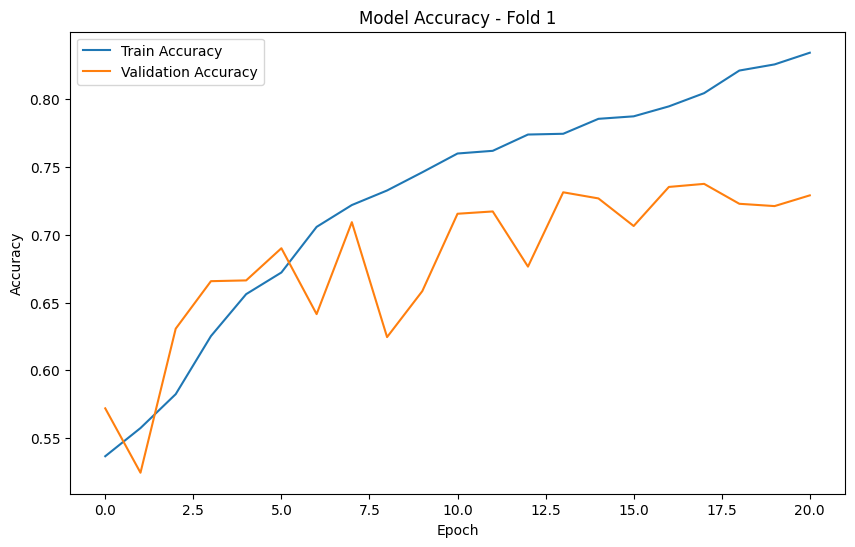

23/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step  

2025-02-13 21:09:02.041562: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

Fold 2/5
Epoch 1/50


/home/ubuntu/data/miniconda3/envs/finetune-dephos/lib/python3.9/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


218/222 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5273 - loss: 2.0450

2025-02-13 21:09:08.213399: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_16}}


222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.5272 - loss: 2.0423 - val_accuracy: 0.6019 - val_loss: 1.5855 - learning_rate: 5.0000e-04
Epoch 2/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.5799 - loss: 1.5869 - val_accuracy: 0.6155 - val_loss: 1.3322 - learning_rate: 5.0000e-04
Epoch 3/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.5845 - loss: 1.3307 - val_accuracy: 0.6330 - val_loss: 1.1456 - learning_rate: 5.0000e-04
Epoch 4/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.6268 - loss: 1.1258 - val_accuracy: 0.6753 - val_loss: 0.9990 - learning_rate: 5.0000e-04
Epoch 5/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.6552 - loss: 0.9922 - val_accuracy: 0.6849 - val_loss: 0.9065 - learning_rate: 5.0000e-04
Epoch 6/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.6711 - loss: 0.8981 - val_accuracy: 0.6844 - val_loss: 0.8373 - learning_rate: 5.0000e-04
Epoch 7/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.69

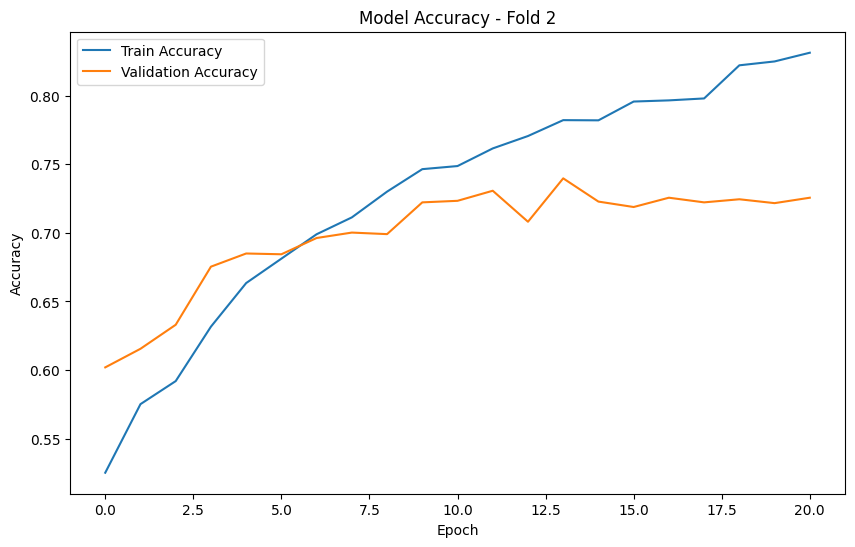

26/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step  

2025-02-13 21:09:57.328260: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

Fold 3/5
Epoch 1/50


/home/ubuntu/data/miniconda3/envs/finetune-dephos/lib/python3.9/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
E0000 00:00:1739481000.700071  245222 meta_optimizer.cc:966] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/functional_2_1/dropout_10_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


217/222 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5374 - loss: 2.0459

2025-02-13 21:10:02.964595: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_16}}


222/222 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.5375 - loss: 2.0427 - val_accuracy: 0.5426 - val_loss: 1.6105 - learning_rate: 5.0000e-04
Epoch 2/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.5632 - loss: 1.6150 - val_accuracy: 0.5313 - val_loss: 1.3832 - learning_rate: 5.0000e-04
Epoch 3/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.6011 - loss: 1.3498 - val_accuracy: 0.6414 - val_loss: 1.1686 - learning_rate: 5.0000e-04
Epoch 4/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.6396 - loss: 1.1524 - val_accuracy: 0.6753 - val_loss: 1.0252 - learning_rate: 5.0000e-04
Epoch 5/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.6541 - loss: 1.0243 - val_accuracy: 0.6855 - val_loss: 0.9244 - learning_rate: 5.0000e-04
Epoch 6/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.6855 - loss: 0.9059 - val_accuracy: 0.7098 - val_loss: 0.8393 - learning_rate: 5.0000e-04
Epoch 7/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.69

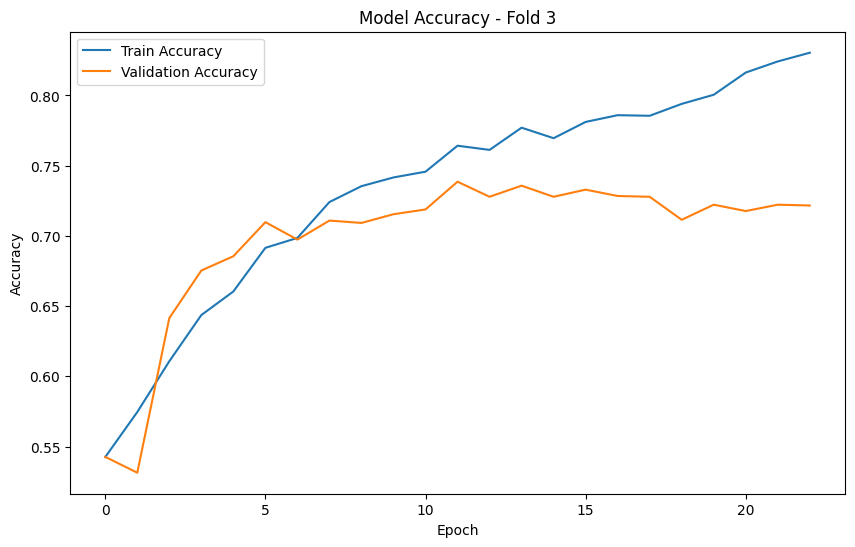

26/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step  

2025-02-13 21:10:53.450182: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

Fold 4/5
Epoch 1/50


/home/ubuntu/data/miniconda3/envs/finetune-dephos/lib/python3.9/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5043 - loss: 2.1556

2025-02-13 21:10:59.939457: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_16}}


222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - accuracy: 0.5044 - loss: 2.1549 - val_accuracy: 0.4921 - val_loss: 1.7164 - learning_rate: 5.0000e-04
Epoch 2/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.5657 - loss: 1.7076 - val_accuracy: 0.5610 - val_loss: 1.4596 - learning_rate: 5.0000e-04
Epoch 3/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.6068 - loss: 1.4131 - val_accuracy: 0.5695 - val_loss: 1.2802 - learning_rate: 5.0000e-04
Epoch 4/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.6340 - loss: 1.2262 - val_accuracy: 0.6616 - val_loss: 1.0682 - learning_rate: 5.0000e-04
Epoch 5/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.6624 - loss: 1.0544 - val_accuracy: 0.6333 - val_loss: 0.9979 - learning_rate: 5.0000e-04
Epoch 6/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.6734 - loss: 0.9534 - val_accuracy: 0.6689 - val_loss: 0.8915 - learning_rate: 5.0000e-04
Epoch 7/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.69

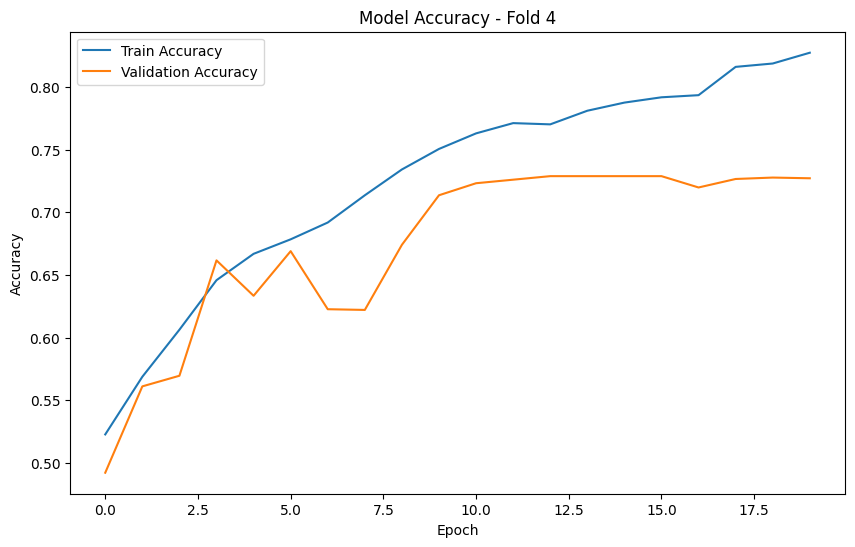

23/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step  

2025-02-13 21:11:45.874857: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

Fold 5/5
Epoch 1/50


/home/ubuntu/data/miniconda3/envs/finetune-dephos/lib/python3.9/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
E0000 00:00:1739481109.356478  245222 meta_optimizer.cc:966] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/functional_4_1/dropout_20_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


221/222 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5199 - loss: 2.1035

2025-02-13 21:11:51.639609: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_16}}


222/222 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.5200 - loss: 2.1023 - val_accuracy: 0.5684 - val_loss: 1.6500 - learning_rate: 5.0000e-04
Epoch 2/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.5551 - loss: 1.6558 - val_accuracy: 0.5062 - val_loss: 1.4575 - learning_rate: 5.0000e-04
Epoch 3/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.5807 - loss: 1.3740 - val_accuracy: 0.5684 - val_loss: 1.2206 - learning_rate: 5.0000e-04
Epoch 4/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.6396 - loss: 1.1508 - val_accuracy: 0.6446 - val_loss: 1.0293 - learning_rate: 5.0000e-04
Epoch 5/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.6286 - loss: 1.0223 - val_accuracy: 0.6503 - val_loss: 0.9304 - learning_rate: 5.0000e-04
Epoch 6/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.6829 - loss: 0.8951 - val_accuracy: 0.6486 - val_loss: 0.8678 - learning_rate: 5.0000e-04
Epoch 7/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.69

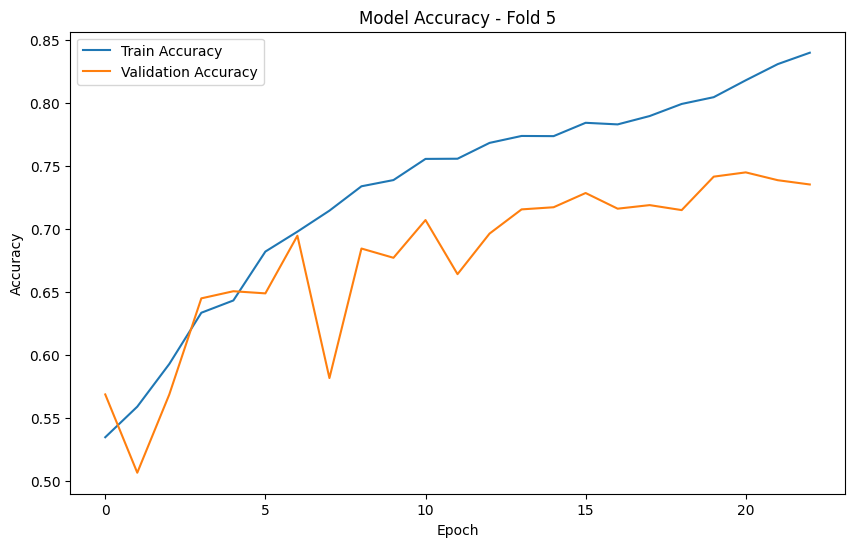

22/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step  

2025-02-13 21:12:44.397888: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

Average Cross-validation Results:
ACC: 0.7322 ± 0.0041
BALANCED_ACC: 0.7310 ± 0.0035
MCC: 0.4645 ± 0.0090
SN: 0.7637 ± 0.0373
SP: 0.6982 ± 0.0354


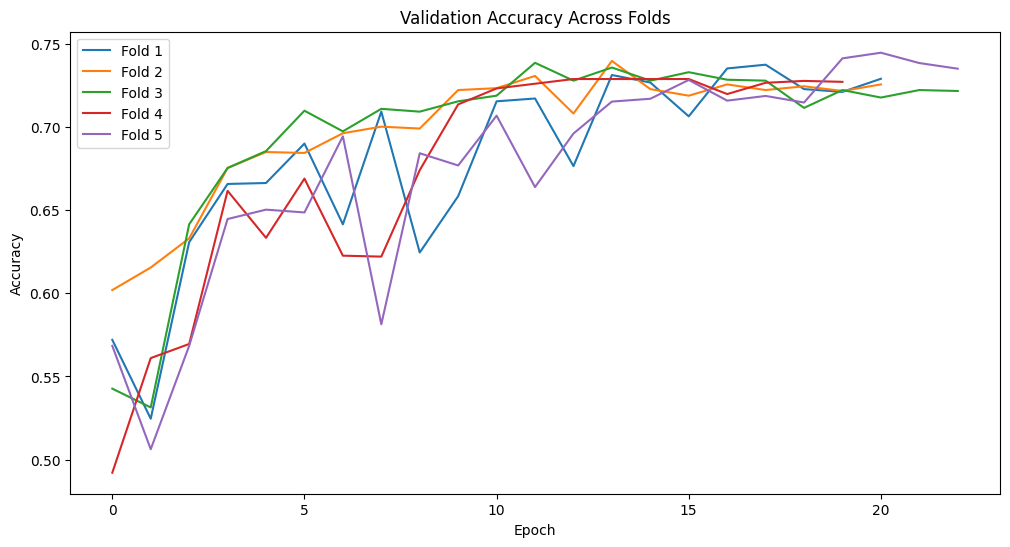


Final Test Set Results:
Accuracy: 0.6927
Balanced Accuracy: 0.7563
MCC: 0.3010
Sensitivity: 0.8333
Specificity: 0.6792
Confusion Matrix:
[[1696  801]
 [  40  200]]


In [11]:

if __name__ == "__main__":
    model = train_and_evaluate_seq_struct()
